# DataQuest - Business Analysis Project: 
## SQL/Python Analysis of Chinook DB

Chinook DB is a sample database that was built to represent the data structure of a hypothetical digital music store. It contains actual song/artist/album info from itunes along with fictional employee data and randomly generated sales data. Chinook.db and more information about its data and schema can be found [here](https://github.com/lerocha/chinook-database).

The goal of this project is to demonstrate analysis using sql within python. I'll also be leveraging pandas and matplotlib for improved visual display of tabular data and plots.

## Import libraries

In [35]:
import sqlite3
from datetime import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
plt.style.use('fivethirtyeight')

## Create SQL query helper functions

These will help to run queries, run commands (like creating views), and view current db status. Setting up the connections using with statements will also ensure that they are closed after the query returns.

1. **run_query(query)** - opens a connection to the db, queries SQL query argument and returns a pandas dataframe of the results.

2. **save_view(command)** - opens the db connection, runs an SQL query execute command, but does not return a pandas dataframe. 

3. **show_tables()** - returns a current list of tables and views in the DB.


In [2]:
db = 'chinook.db'

def run_query(q):
    with sqlite3.connect(db) as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect(db) as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    query = """\
    SELECT
        name,
        type
    FROM
        sqlite_master
    WHERE type IN ('table', 'view');
    """
    return run_query(query)

In [3]:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


## Question 1: Which artists should Chinook launch?

#### Prompt:

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

|Artist Name | Genre |
|---|---|
|Regal |	Hip-Hop
|Red Tone |	Punk
|Meteor and the Girls |	Pop
|Slim Jim Bites |	Blues

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

#### Methodology

In order to answer this, I'll need to access data from four different tables in Chinook;
1. **invoice_line** - contains both the quantity field (# of tracks sold) that I'll need to aggregate and the track_id field which I'll need to link the sales back to genres.
2. **invoice** - contains the billing_country field, which will be used to filter results to 'USA' customers only.
3. **genre** - contains the genre name, but is not linked to either invoice_line or invoice.
4. **track** - contains none of the info needed for the answer, but it does contain the 'genre_id' field and the 'track_id' fields, both of which will be required to link the genre table to invoice_line table.

Plan to build the SQL query to access each using with statements as subqueries:
1. Reduce invoice table to USA billing only. Return invoice_ids.
2. Use the results to filter invoices_line (inner join with invoice_ids from step 1).
3. Add genre info: Left join with track, then left join with genre.
4. Aggregate quantity of track sales by genre in the resulting table. Join this with a query that calculates the total number of tracks sold to be used in calculating % of tracks sold by genre.

#### Recommendation

Based on past Chinook's sales history, songs in the Hip-Hop/Rap genre are the lowest selling of four genres of records that the new lable has to offer at only 1.9% of tracks sold. Chinook should lead with Red Tone from the punk genre which makes up 12.4% of sales. The second priority launch should be Slim Jim Bites in the Blues genre, 3.4% of Chinook's business. Finally, the third priority launch should be Meteor and the Girls from the Pop genre which makes up 2.1% of total track sales.


In [4]:
q1 = """
    /* step 1 */
    WITH usa AS 
            (
            SELECT invoice_id
            FROM invoice
            WHERE billing_country = 'USA'
            ),

    /* step 2 */
    sales AS 
            (
            SELECT
                i.track_id,
                sum(i.quantity) as quantity
            FROM 
                invoice_line i
                    INNER JOIN usa
                    ON i.invoice_id = usa.invoice_id
            GROUP BY track_id
            ),
    
    /* step 3 */
    category AS 
            (
            SELECT 
                s.track_id, 
                s.quantity, 
                g.name as genre
            FROM
                sales s
                    LEFT JOIN track t
                    ON s.track_id = t.track_id
                    LEFT JOIN genre g
                    ON g.genre_id = t.genre_id
            )
    
    /* step 4 */
    SELECT
        genre,
        SUM(quantity) as "tracks_sold",
        ROUND((SUM(quantity) / (SELECT TOTAL(quantity) FROM category) * 100), 2) 
            AS "pct_tracks_sold"
    FROM category 
    GROUP BY genre
    ORDER BY 2 DESC;
"""

In [5]:
genre_sales = run_query(q1)
run_query(q1)

,genre,tracks_sold,pct_tracks_sold
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Latin,22,2.09
7,Pop,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


In [6]:
#Reset dataframe index to genre names for easier labeling.
genre_sales.set_index("genre",drop=True,inplace=True)

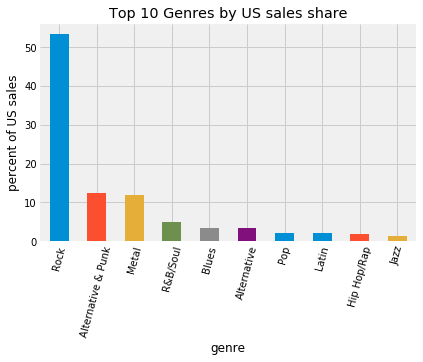

In [7]:
ax1 = genre_sales['pct_tracks_sold'].sort_values(ascending=False).head(10).plot.bar(rot=75)
ax1.set_xlabel("genre")
ax1.set_ylabel("percent of US sales")
ax1.set_title("Top 10 Genres by US sales share")
for spine in ax1.spines:
    ax1.spines[spine].set_visible(False)
ax1.tick_params(left=False, bottom=False)


## Question 2: Which sales employees are the most productive?

#### Prompt

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. You have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

#### Methodology

In assessing performance for sales reps, the most significant relationship in the dataset would be between them and their customer's total purchases, but just using this total for comparison would be misleading. Consider first that sales employees have not worked at Chinook for the same length of time. Second, Chinook sales reps do not have the same 'territory' sizes, which is also a hard thing to measure as we do not know anything about Chinook's sales operations. I'll have to make some assumptions.

First, I'll assume that we're measuring performance relative to tenure. Normalizing sales in this way will give a better representation of productivity.

Next, in order to account for the territory size issue, I'll be assuming that the reps have a finite number of customers assigned to them as there territory. This means that a sales person's productivity is not contingent on their customer count, but rather on their sales per customer.

Combining these two metrics gives us the **total sales / customer / month** metric which we can use to plot performance in a time series and compare between reps.

**Note: the data was randomized through 2020, so future dates are valid.**

**Steps to query:**

Like in the previous question, the information that we need is dispersed across several tables. This time it is contained in the employee, customer, and invoice tables.

Query plan:
1. Extract month + year field out of invoice_date in invoice. This can be a text field as it will work in a time series plot. Return Customer ID, Total Sales by Month/Year field.
2. Left Join resulting table to customer on customer ID, then to employee on support_rep_id = employee_id. Aggregate monthly sales by customer rep and month. Calculate customer count.
3. Calculate sales per customer. Resulting table should have these columns;
    - employee name
    - year/month
    - quantity sold / customer count.




In [8]:
q2 = """
WITH 
    /*  Step  1 */
    monthly_billings 
        AS (
            SELECT 
                customer_id,
                SUBSTR(invoice_date, 1, 4) || SUBSTR(invoice_date, 6, 2) as month,
                SUM(total) as sales
            FROM INVOICE
            GROUP BY 1, 2
            ),

    /*  Step  2 */
    rep_performance
        AS (
            SELECT
                e.first_name || " " || e.last_name as sales_rep,
                m.customer_id,
                m.month,
                m.sales
            FROM monthly_billings m
                INNER JOIN customer c 
                ON c.customer_id = m.customer_id
                INNER JOIN employee e
                ON c.support_rep_id = e.employee_id
            WHERE lower(e.title) LIKE'%sales%'
            ORDER BY sales_rep, month
            )

/*  Step  3 */
SELECT
    sales_rep,
    month as month,
    ROUND(CAST(TOTAL(sales) AS float) / CAST(COUNT(customer_id) AS float), 2) AS sales_per_cust
FROM rep_performance
GROUP BY sales_rep, month
ORDER BY sales_rep, month

"""

rep_df = run_query(q2)
print(rep_df.head())
print(rep_df.tail())

      sales_rep   month  sales_per_cust
0  Jane Peacock  201701           11.46
1  Jane Peacock  201702            8.22
2  Jane Peacock  201703            8.17
3  Jane Peacock  201704           10.52
4  Jane Peacock  201705           11.38
         sales_rep   month  sales_per_cust
136  Steve Johnson  202008            8.58
137  Steve Johnson  202009           10.56
138  Steve Johnson  202010            7.13
139  Steve Johnson  202011            7.67
140  Steve Johnson  202012            4.95


#### Convert dates and reshape dataframe for easier time series plotting.

In [9]:
#convert dates, set index, pivot
rep_df['month'] = pd.to_datetime(rep_df['month'], format='%Y%m')
rep_df = rep_df.pivot(index='month', values='sales_per_cust', columns='sales_rep')

In [10]:
#aggregate to annual summary
annual_summary = pd.DataFrame()
for col in rep_df.columns:
    col_name = col.replace(' ', '_')
    annual_summary[col_name] = rep_df[col].resample('A').mean()

print(round(annual_summary, 2))

            Jane_Peacock  Margaret_Park  Steve_Johnson
month                                                 
2017-12-31          9.59           7.58           7.19
2018-12-31          9.09           8.92           7.92
2019-12-31          8.88           8.53           8.50
2020-12-31          8.91           7.90           7.82


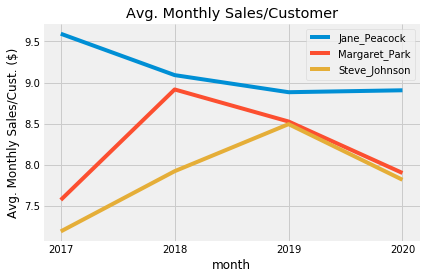

In [11]:
#Plot performance
ax2 = annual_summary.plot(title='Avg. Monthly Sales/Customer')
for spine in ax2.spines:
    ax2.spines[spine].set_visible(False)
ax2.tick_params(left=False)
ax2.set_ylabel("Avg. Monthly Sales/Cust. ($)")
plt.show()

#### Results

When ranked by average sales per customer, the most productive sales rep. at Chinook is consistantly Jane Peacock. She not only set the record for highest annual sales/customer average at $9.59 in 2017, but she has finished in first place among her peers in each year following. Margaret Park has held the second place position each year.

# Question 3: Sales by country

#### Prompt: For each geographic region listed in the customer table, identify the following;
- total number of customers
- total value of sales
- average value of sales per customer
- average order value

The results should be sorted by the total sales from highest to lowest, with the "Other" group at the very bottom.

#### Query plan:

To create a view that answers each of these, I'll need to access two of the three tables from the last query, but this time I'll need to make sure that all geographic regions listed in the customer table are represented. Additionally, I'll be pushing the long-tail countries into a category called "Other". This will include any countries with only one customer.

1. Start with the customer table and left join with invoices. Return customer count, invoice count and total sales by country.
2. Label countries with only one customer as "All Other Countries". Add a sort column that assins Other to 1 and everything else to 0 so Other can be moved to the bottom of the list in sort.
3. Final query calculate sales/customer and sales/invoice, aggregated by country and sorted.


In [12]:
q3 = """
with 
    /* STEP 1 */
    billings AS 
            (
            SELECT  
                c.country,
                COUNT(DISTINCT c.customer_id) as n_customer,
                COUNT(DISTINCT i.invoice_id) as n_invoice,
                TOTAL(i.total) as sales
            FROM 
                customer c
                    LEFT JOIN invoice i
                    ON c.customer_id = i.customer_id
            GROUP BY c.country
            ),

    /* STEP 2 */
    world AS
            (
            SELECT
                CASE 
                    WHEN n_customer > 1 THEN country
                    ELSE "All Other Countries"
                END AS country_alias,
                n_customer,
                n_invoice,
                sales,
                CASE
                    WHEN n_customer > 1 THEN 0
                    ELSE 1
                END AS sort_col
            FROM
                billings
            )

/* STEP 3 */
SELECT 
    country_alias AS country,
    SUM(n_customer) AS n_customers,
    SUM(n_invoice) AS n_invoices,
    TOTAL(sales) AS ttl_sales,
    ROUND(CAST(TOTAL(sales) AS float) / CAST(sum(n_invoice) AS float),2) AS avg_invoice_ttl,
    ROUND(CAST(total(sales) AS float) / CAST(sum(n_customer) AS float),2) AS avg_cust_spend,
    ROUND(CAST(SUM(n_invoice) AS float) / CAST(SUM(n_customer) AS float), 2) AS invoices_per_cust
FROM world
GROUP BY country
ORDER BY 
    sort_col, 
    ttl_sales desc;

"""

world = run_query(q3)
world = world.set_index('country')
run_query(q3)


,country,n_customers,n_invoices,ttl_sales,avg_invoice_ttl,avg_cust_spend,invoices_per_cust
0,USA,13,131,1040.49,7.94,80.04,10.08
1,Canada,8,76,535.59,7.05,66.95,9.50
2,Brazil,5,61,427.68,7.01,85.54,12.20
3,France,5,50,389.07,7.78,77.81,10.00
4,Germany,4,41,334.62,8.16,83.65,10.25
5,Czech Republic,2,30,273.24,9.11,136.62,15.00
6,United Kingdom,3,28,245.52,8.77,81.84,9.33
7,Portugal,2,29,185.13,6.38,92.56,14.50
8,India,2,21,183.15,8.72,91.57,10.50
9,All Other Countries,15,147,1094.94,7.45,73.00,9.80


#### Results

The United States is the largest market for Chinook on a total sales basis due to its high customer count, but has an opportunity to increase sales by increasing average customer spend.

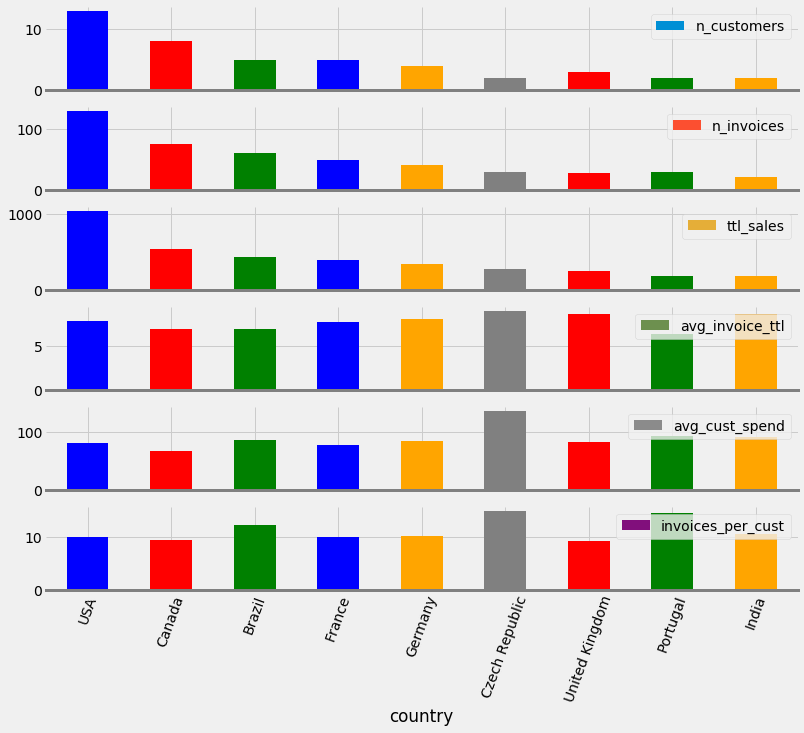

In [47]:
world_updated = world[~world.index.isin(['All Other Countries'])]
world_updated = world_updated.copy()
ax3 = world_updated.plot(kind='bar', subplots=True, rot=70, figsize=(12,10))
for i in ax3:
    i.set_title("")
    for spine in i.spines:
        i.spines[spine].set_visible(False)
        i.spines['bottom'].set_visible(True)
        i.spines['bottom'].set_color('grey')
    i.legend(loc='upper right')
    i.patches[0].set_facecolor('b')
    i.patches[1].set_facecolor('r')
    i.patches[2].set_facecolor('g')
    i.patches[3].set_facecolor('b')
    i.patches[4].set_facecolor('orange')
    i.patches[5].set_facecolor('grey')
    i.patches[6].set_facecolor('red')
    i.patches[7].set_facecolor('green')
    i.patches[8].set_facecolor('orange')


In [14]:
#ToDO: find more pythonic way to assign colors.

# Question 4: What % of invoices are for entire albums?

#### Prompt: 

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

#### Approach

To answer this, we need to use the invoice_line table to first identify which album is being purchased. We can then link this table to the album_id field in the track table to get a full list of songs from that album. In comparing the two lists, if we find that all songs from the album are also contained in the invoice, then it is a full album purchase. If there are songs on the album that were not purchased, then it is a single song purchase. Once we have coded the list of invoices using this logic, then we can calculate the % of purchases which are full albums.

#### Query Plan:
1. Create a table with the first track purchased on each invoice and the corresponding album_id that the track is found on by joining invoice_line and track tables.
2. Create a case statement that compares tracks on the album that the first song is found on to all tracks on the invoice #s created in step 1. Use EXCEPT comparisons inside of the case statement to determine if there are differences in the two lists of tracks (album/invoice). Return a 1 in a 'full_album' field if the invoice is for the full album or a 0 if there are tracks on the album that were not purchased.
3. Divide the resulting sum of the full_album field by the total number of invoices to calculate the percentage of invoices which include full albums.

#### Results and Recommendation:

Examining Chinook's invoices shows that 18.6% of invoices contain full album purchases, while the remaining 81.4% contain a la carte tracks only. My opinion is that changing purchasing strategies would backfire on Chinook as they would alienate the nearly 1/5 of their shopper base that have already indicated through their purchases that they prefer to buy full albums.

In [97]:
q4 = """
/* Step 1 */
WITH
    invoice_first_track AS 
        (
        SELECT
            i.invoice_id,
            MIN(i.track_id) as first_track_id,
            t.album_id
        FROM
            invoice_line i
                LEFT JOIN track t
                ON i.track_id = t.track_id
        GROUP BY 1
        ),
    
    /* Step 2 */
    full_album_calc AS
        (
        SELECT ift.*,
            CASE
                WHEN
                    (
                        (
                            /* Tracks on Invoice */
                            SELECT track_id             
                            FROM invoice_line il
                            WHERE il.invoice_id = ift.invoice_id

                            EXCEPT

                            /* Tracks on Album */
                            SELECT track_id
                            FROM track t
                            WHERE ift.album_id = t.album_id

                        ) IS NULL
                    AND
                        (
                            /* Tracks on Album */
                            SELECT track_id
                            FROM track t
                            WHERE ift.album_id = t.album_id

                            EXCEPT 

                            /* Tracks on Invoice */
                            SELECT track_id             
                            FROM invoice_line il
                            WHERE il.invoice_id = ift.invoice_id

                        ) IS NULL
                    )
                THEN 1
                ELSE 0
            END as full_album
        FROM invoice_first_track ift
        )
        
/* Step 3 */
SELECT 
    ROUND(CAST(SUM(f.full_album) AS float) / CAST(COUNT(f.full_album) AS float) * 100,2) as "pct_full_album"
FROM full_album_calc f


"""

run_query(q4)

,pct_full_album
0,18.57


# TODO:

1. This notebook demonstrates SQL ability, however; the data visualizations need improvement, particularly the results from question 4, which could be turned into more of a 'dashboard' type display with calculated fields.